# **CNN-based Food Image Recognition**

**Objective:**

Build a model using Convolutional Neural Network algoirithm to analyze and identify patterns in food images. Then the model can be used to recognize any unseen images.

**Dataset**

This project used Food101 Tensorflow Dataset. This dataset consists of 101 food categories, with 101,000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.

**Modeling Steps**
1. Extract pixel features from an image
2. Build Neural Network architecture
3. Train model with training set (labelled images)
4. Fine tune model to improve the performance
5. Test model with testing set and evaluate it
6. Test the final model with custom images

# **Data**

In [ ]:
# Get the dataset
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
dataset_list = tfds.list_builders()
print("food101" in dataset_list)

True


In [ ]:
# Load in the data in tuple format
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train","validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # download dataset in tuple format, not in dictionary format
                                             with_info=True) # download dataset metadata

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteSQ0XUW/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteSQ0XUW/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Check the feature of the food101 dataset
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [ ]:
# Get 1 sample of the training data in format (image_tensor, label)
train_sample = train_data.take(1)
train_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Get the info of train sample
for image, label in train_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class: {label}
  Class name: {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class: 18
  Class name: chicken_curry
  


In [ ]:
# Check the image tensor
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[170, 193, 165],
        [175, 198, 170],
        [187, 209, 186],
        ...,
        [253, 255, 249],
        [253, 255, 249],
        [253, 255, 249]],

       [[169, 185, 159],
        [169, 184, 161],
        [171, 189, 167],
        ...,
        [253, 255, 249],
        [253, 255, 249],
        [253, 255, 249]],

       [[166, 171, 151],
        [161, 166, 146],
        [158, 165, 147],
        ...,
        [253, 255, 249],
        [253, 255, 249],
        [253, 255, 249]],

       ...,

       [[143, 131, 105],
        [143, 131, 105],
        [141, 132, 103],
        ...,
        [152, 131, 104],
        [153, 129, 103],
        [151, 127, 101]],

       [[139, 129, 102],
        [138, 128, 101],
        [137, 128,  99],
        ...,
        [150, 126, 100],
        [151, 125, 100],
        [152, 126,  99]],

       [[133, 123,  96],
        [134, 124,  97],
        [136, 127,  98],
        ...,
        [149, 125,  9

In [ ]:
# Check the min and max value of image tensor
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=5>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Image tensors have values in range 5-255. This value is a representation of pixel intensity of a single color channel (Red/Green/Blue).

(-0.5, 511.5, 511.5, -0.5)

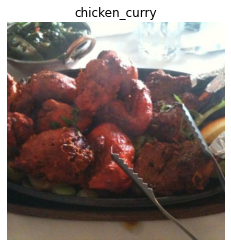

In [ ]:
# Plot the image tensor
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

The data currently:
1. has uint8 data type
2. has different size tensor images
3. is not scaled (pixel intensity values are between 0 and 255

# **Preprocessing Data**

## **Convert Data Type, Image Size, Scale Image**

The data must be:
1. in float32 data type
2. in the same tensor size
3. scaled

In [ ]:
# Create preprocessing image function
def preprocess_img(image, label, img_shape=224):
  """
  Convert image data type from uint8 to float32
  Reshape image to [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [ ]:
# Preprocess the sample image
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[170 193 165]
  [175 198 170]
  [187 209 186]
  ...
  [253 255 249]
  [253 255 249]
  [253 255 249]]

 [[169 185 159]
  [169 184 161]
  [171 189 167]
  ...
  [253 255 249]
  [253 255 249]
  [253 255 249]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[170.5051  188.59184 163.11736]
  [187.9898  206.82143 186.91837]
  [208.97958 225.69388 212.7653 ]
  ...
  [253.      255.      249.     ]
  [253.      255.      249.     ]
  [253.      255.      249.     ]]

 [[155.02551 149.47958 134.38776]
  [149.11224 149.47958 137.11734]
  [153.97449 162.87245 152.42857]
  ...
  [253.      255.      249.     ]
  [253.      255.      249.     ]
  [253.      255.      249.     ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


(-0.5, 223.5, 223.5, -0.5)

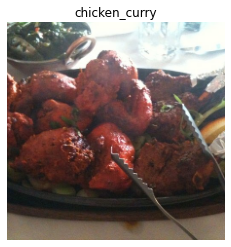

In [ ]:
# plot the preprocessed sample image
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False)

## **Batching the Dataset**

**Map** the preprocessing image function (preprocess_img) across the training dataset, then **shuffle** a number of elements before **batching** them together and prepare new batches (**prefetch**) whilst the model is looking through the current batch.

In [ ]:
import tensorflow as tf
# Map preprocessing function to training data
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
  # num_parallel_calls=tf.data.AUTOTUNE will parallelize preprocessing and significantly improve speed

# shuffle train_data, turn it into batch, and prefetch another batches
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
  # buffer_size is the number of data that will be shuffled for selecting 32 images, and set them in one batch


# Map preprocessing function to testing data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# shuffle train_data, turn it into batch, and prefetch another batches
test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# check the train and test data
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## **Create Callbacks**

1. **Tensorboard Callback** - to keep track of the model's training history so can inspect it later.
2. **ModelCheckPoint Callback** - to save the  model's progress so can load it and resuse it later without having to retrain it.

In [ ]:
!wget https://raw.githubusercontent.com/dinachoir/Convolutional-Neural-Network/main/functions.py

from functions import create_tensorboard_callback

--2022-07-06 04:39:21--  https://raw.githubusercontent.com/dinachoir/Convolutional-Neural-Network/main/functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9352 (9.1K) [text/plain]
Saving to: ‘functions.py’

functions.py        100%[===================>]   9.13K  --.-KB/s    in 0s      

2022-07-06 04:39:22 (69.3 MB/s) - ‘functions.py’ saved [9352/9352]



In [ ]:
checkpoint_path = "efficientnetb0_model_checkpoints" # save weights in .ckpt
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## **Setup Mixed Precision Training**

Mixed precision training involves using a mix of float16 and float32 tensors to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

In [ ]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-187c0b28-1207-55c6-7c9f-49a2307a684b)


In [ ]:
# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)

2.8.2


In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
# Check the global dtype policy
mixed_precision.global_policy()

<Policy "mixed_float16">

# **Feature Extraction Transfer Learning Model 1 (EfficientNetB0)**

**Modeling Setup:**

1. Modeling using Keras Functional API (Put together the input layer, base model layer, pooling layer, and output layer in a functional model)
2. Using tf.keras.applications.EfficientNetB0 as the base model
3. Using include_top=False parameter to add customized output layers
4. Using GlobalAveragePooling2D layer to condense the outputs of the base model into a shape that compatible in the output layer (Dense layer).
5. Using the Adam optimizer and sparse categorical crossentropy as the loss function (since the labels aren't one-hot encoded)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create the base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze the base model layer, so model can use the pre-learned patterns the base model has found on ImageNet

# Create Functional Model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Check Model's architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Check the dtype_policy attributes of layers in the model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Fit the model
history_101_food_feature_extraction = model.fit(train_data,
                                                epochs=3,
                                                steps_per_epoch=len(train_data),
                                                validation_data=test_data,
                                                validation_steps=int(0.15*len(test_data)),
                                                callbacks=[create_tensorboard_callback("training_log",
                                                                                       "efficientnetb0_100%_101Food_feature_extraction"),
                                                           model_checkpoint])

Saving Tensorboard log files to training_log/efficientnetb0_100%_101Food_feature_extraction/20220705-065416
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0450 - accuracy: 0.7264WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 169s 70ms/step - loss: 1.0450 - accuracy: 0.7264 - val_loss: 1.0725 - val_accuracy: 0.7021
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 0.9719 - accuracy: 0.7447WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 168s 70ms/step - loss: 0.9718 - accuracy: 0.7447 - val_loss: 1.0820 - val_accuracy: 0.7116
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 0.9152 - accuracy: 0.7580WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 167s 70ms/step - loss: 0.9152 - accuracy: 0.7580 - val_loss: 1.0746 - val_accuracy: 0.7103


In [ ]:
# Evaluate model on test data
eval_feature_extraction_model = model.evaluate(test_data)
eval_feature_extraction_model

790/790 [==============================] - 52s 63ms/step - loss: 1.0669 - accuracy: 0.7115


[1.066857933998108, 0.7114851474761963]

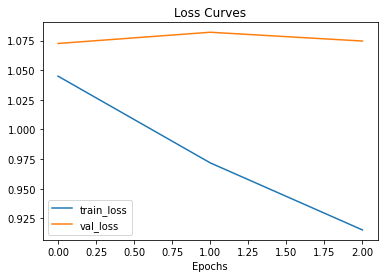

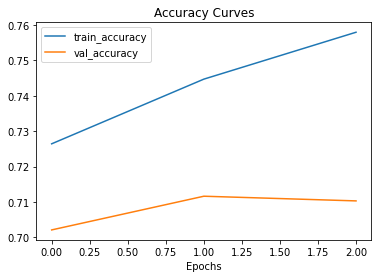

In [ ]:
from functions import plot_loss_accuracy

plot_loss_accuracy(history_101_food_feature_extraction)

In [ ]:
import os
# To save model to Google Drivw
## create save path to GD
save_dir = "drive/MyDrive/Tensorflow/efficientnetb0_100%_101food_feature_extraction/"
os.makedirs(save_dir) # if directory doesn't exist

## save model
model.save(save_dir)

# To save model in current directory
save_dir = "efficientnetb0_100%_101food_feature_extraction"
model.save(save_dir)

INFO:tensorflow:Assets written to: drive/MyDrive/Tensorflow/efficientnetb0_100%_101food_feature_extraction/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Tensorflow/efficientnetb0_100%_101food_feature_extraction/assets


INFO:tensorflow:Assets written to: efficientnetb0_100%_101food_feature_extraction/assets


INFO:tensorflow:Assets written to: efficientnetb0_100%_101food_feature_extraction/assets


# **Fine Tuning Model 1**

In [ ]:
# Set all layers to trainable (because fine tuning model using 100% of the data)
for layer in model.layers:
  layer.trainable=True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


## **Create EarlyStopping Callback**

This callback stops training when a monitored metric has stopped improving.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3) # if val_loss increases for 3 epochs, then training will be stopped

## **Create ModelCheckpoint Callback**

In [ ]:
# Create ModelCheckpoint callback to save the best model during fine tuning
checkpoint_path = "efficientnetb0_fine_tuned_checkpoints"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## **Create ReduceLROnPlateau Callback**

To monitor the validation loss just like EarlyStopping callback. It reduce the learning rate by a specified factor to get closer to the ideal performance.

For instance, once the validation loss stops improving for two or more epochs (custom value) in a row, ReduceLROnPlateau Callback will reduce the learning rate by 5, so the learning rate will be 0.001 --> 0.0002 --> 0.00005 --> so on until the minimum learning rate (e.g. 0.0000007).

In [ ]:
# Learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

## **Re-Compile & Fit the Model**

In [ ]:
# re-compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # 10x lower than feature extraction model
              metrics=["accuracy"])

In [ ]:
# Fit the model
history_101_food_fine_tuning = model.fit(train_data,
                                         epochs=100, # maximum epochs for fine tuning
                                         steps_per_epoch=len(train_data),
                                         validation_data=test_data,
                                         validation_steps=int(0.15*len(test_data)),
                                         callbacks=[create_tensorboard_callback("training_log",
                                                                                "efficientnetb0_100%_101Food_fine_tuning"),
                                                    model_checkpoint,
                                                    early_stopping,
                                                    reduce_lr])

Saving Tensorboard log files to training_log/efficientnetb0_100%_101Food_fine_tuning/20220705-071345
Epoch 1/100
2368/2368 [==============================] - 353s 142ms/step - loss: 0.8270 - accuracy: 0.7724 - val_loss: 0.8359 - val_accuracy: 0.7696 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 343s 144ms/step - loss: 0.5008 - accuracy: 0.8599 - val_loss: 0.8629 - val_accuracy: 0.7730 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.2812 - accuracy: 0.9188
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 336s 141ms/step - loss: 0.2812 - accuracy: 0.9188 - val_loss: 0.9520 - val_accuracy: 0.7688 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 337s 142ms/step - loss: 0.0660 - accuracy: 0.9843 - val_loss: 1.0312 - val_accuracy: 0.7815 - lr: 2.0000e-05


In [ ]:
# Evaluate the model on test data
eval_fine_tuning_model = model.evaluate(test_data)
eval_fine_tuning_model

790/790 [==============================] - 52s 63ms/step - loss: 1.0134 - accuracy: 0.7864


[1.0133843421936035, 0.7863762378692627]

In [ ]:
# To save model to Google Drivw
## create save path to GD
#save_dir = "drive/MyDrive/Tensorflow/efficientnetb0_100%_101food_fine_tuning/"

## save model
#model.save(save_dir)

# To save model in current directory
save_dir = "efficientnetb0_100%_101food_fine_tuning"
model.save(save_dir)

INFO:tensorflow:Assets written to: efficientnetb0_100%_101food_fine_tuning/assets


INFO:tensorflow:Assets written to: efficientnetb0_100%_101food_fine_tuning/assets


## **Performance Comparation**

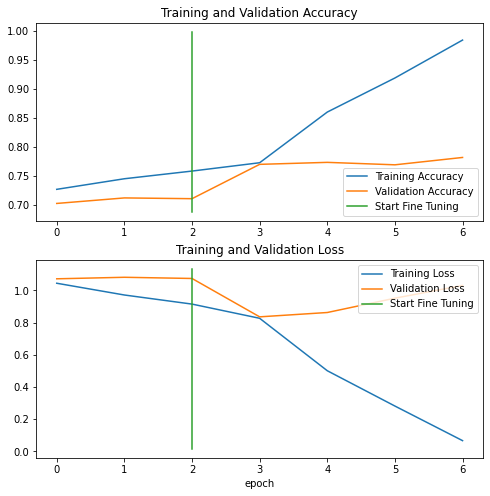

In [ ]:
# Compare performance model before and after fine tuning
from functions import compare_historys
compare_historys(original_history=history_101_food_feature_extraction,
                 new_history=history_101_food_fine_tuning,
                 initial_epochs=3)

# **Feature Extraction Transfer Learning Model 2 (EfficientNetB4)**

**Modeling Setup:**

1. Modeling using Keras Functional API (Put together the input layer, base model layer, pooling layer, and output layer in a functional model)
2. Using tf.keras.applications.EfficientNetB4 as the base model
3. Using include_top=False parameter to add customized output layers
4. Using GlobalAveragePooling2D layer to condense the outputs of the base model into a shape that compatible in the output layer (Dense layer).
5. Using the Adam optimizer and sparse categorical crossentropy as the loss function (since the labels aren't one-hot encoded)

In [ ]:
# Create ModelCheckpoint callback
checkpoint_path = "efficientnetb4_model_checkpoints"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create the base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False # freeze the base model layer, so model can use the pre-learned patterns the base model has found on ImageNet

# Create Functional Model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Check Model's architecture
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 pooling_layer (GlobalAverag  (None, 1792)             0         
 ePooling2D)                                                     
                                                                 
 dense_1 (Dense)             (None, 101)               181093    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 17,854,916
Trainable params: 181,093
Non-trai

In [ ]:
# Fit the model
history_101_food_feature_extraction_b4 = model_2.fit(train_data,
                                                epochs=3,
                                                steps_per_epoch=len(train_data),
                                                validation_data=test_data,
                                                validation_steps=int(0.15*len(test_data)),
                                                callbacks=[create_tensorboard_callback("training_log",
                                                                                       "efficientnetb4_100%_101Food_feature_extraction"),
                                                           model_checkpoint])

Saving Tensorboard log files to training_log/efficientnetb4_100%_101Food_feature_extraction/20220706-044247
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8680 - accuracy: 0.5392WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 323s 125ms/step - loss: 1.8680 - accuracy: 0.5392 - val_loss: 1.3265 - val_accuracy: 0.6515
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.3870 - accuracy: 0.6405WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 291s 122ms/step - loss: 1.3870 - accuracy: 0.6405 - val_loss: 1.2327 - val_accuracy: 0.6764
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2386 - accuracy: 0.6753WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 291s 122ms/step - loss: 1.2386 - accuracy: 0.6753 - val_loss: 1.1973 - val_accuracy: 0.6803


In [ ]:
# Evaluate model on test data
eval_feature_extraction_model_b4 = model_2.evaluate(test_data)
eval_feature_extraction_model_b4

790/790 [==============================] - 90s 112ms/step - loss: 1.1966 - accuracy: 0.6790


[1.1966238021850586, 0.6790494918823242]

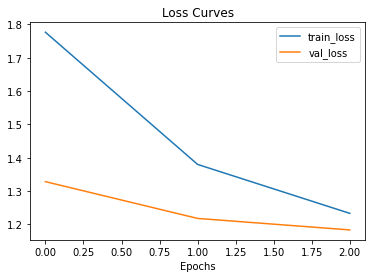

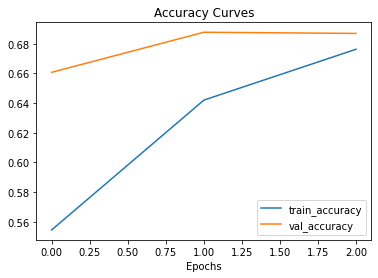

In [ ]:
from functions import plot_loss_accuracy

plot_loss_accuracy(history_101_food_feature_extraction_b4)

# **Fine Tuning Model 2**

In [ ]:
# Set all layers to trainable (because fine tuning model using 100% of the data)
for layer in model_2.layers:
  layer.trainable=True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb4 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Create ModelCheckpoint callback to save the best model during fine tuning
checkpoint_path = "efficientnetb4_fine_tuned_checkpoints"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [ ]:
# re-compile the model
model_2.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # 10x lower than feature extraction model
              metrics=["accuracy"])

In [ ]:
# Fit the model
history_101_food_fine_tuning_b4 = model_2.fit(train_data,
                                         epochs=100, # maximum epochs for fine tuning
                                         steps_per_epoch=len(train_data),
                                         validation_data=test_data,
                                         validation_steps=int(0.15*len(test_data)),
                                         callbacks=[create_tensorboard_callback("training_log",
                                                                                "efficientnetb4_100%_101Food_fine_tuning"),
                                                    model_checkpoint,
                                                    early_stopping,
                                                    reduce_lr])

Saving Tensorboard log files to training_log/efficientnetb4_100%_101Food_fine_tuning/20220706-050300
Epoch 1/100
2368/2368 [==============================] - 834s 336ms/step - loss: 0.9214 - accuracy: 0.7513 - val_loss: 0.7060 - val_accuracy: 0.8024 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 786s 331ms/step - loss: 0.3925 - accuracy: 0.8896 - val_loss: 0.7384 - val_accuracy: 0.8019 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.9577
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 791s 333ms/step - loss: 0.1391 - accuracy: 0.9577 - val_loss: 0.8913 - val_accuracy: 0.7961 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 788s 332ms/step - loss: 0.0230 - accuracy: 0.9942 - val_loss: 0.8998 - val_accuracy: 0.8308 - lr: 2.0000e-05


In [ ]:
# Evaluate the model on test data
eval_fine_tuning_model_b4 = model_2.evaluate(test_data)
eval_fine_tuning_model_b4

790/790 [==============================] - 95s 116ms/step - loss: 0.9002 - accuracy: 0.8271


[0.9001911282539368, 0.8271287083625793]

## **Performance Comparation**

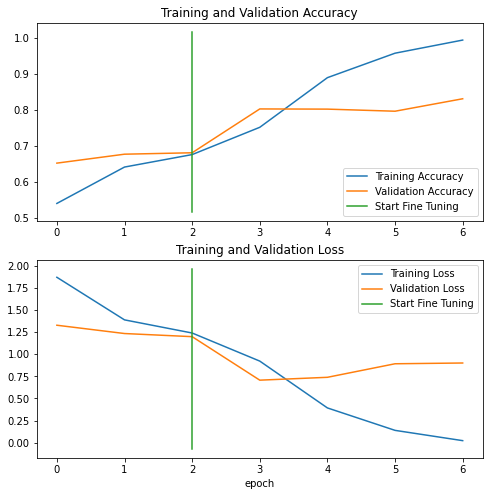

In [ ]:
# Compare performance model before and after fine tuning
from functions import compare_historys
compare_historys(original_history=history_101_food_feature_extraction_b4,
                 new_history=history_101_food_fine_tuning_b4,
                 initial_epochs=3)

# **Model Comparation Using TensorBoard**

https://tensorboard.dev/experiment/K8yrayIjTbu4ROvpRKfbEQ/

In [ ]:
!tensorboard dev upload --logdir ./training_log \
  --name "Food101 EfficientNetB0 vs. EfficientNetB4 Model" \
  --description "A transfer learning experiments with feature extraction and fine-tuning" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/K8yrayIjTbu4ROvpRKfbEQ/

[2022-07-05T09:39:04] Started scanning logdir.
[2022-07-05T09:39:15] Total uploaded: 102 scalars, 0 tensors, 6 binary objects (8.4 MB)
[2022-07-05T09:39:15] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/K8yrayIjTbu4ROvpRKfbEQ/


In [ ]:
# To save model in current directory
save_dir = "efficientnetb4_100%_101food_fine_tuning.h5"
model_2.save(save_dir)

In [ ]:
# To load checkpoint weights into model
cloned_model = tf.keras.models.clone_model(model_2)
cloned_model.load_weights(checkpoint_path)

In [ ]:
# load model from checkpoint
model_2.load_weights(checkpoint_path)

In [ ]:
checkpoint_path

'efficientnetb4_fine_tuned_checkpoints'

# **Model Evaluation (EfficientNetB4)**

In [ ]:
# Load in the data in tuple format
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train","validation"],
                                             shuffle_files=False,
                                             as_supervised=True, # download dataset in tuple format, not in dictionary format
                                             with_info=True) # download dataset metadata

In [ ]:
# Map preprocessing function to testing data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# shuffle train_data, turn it into batch, and prefetch another batches
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# Prediction probability
pred_probs = model_2.predict(test_data, verbose=1)

790/790 [==============================] - 88s 106ms/step


In [ ]:
# Prediction probability tensor shape
pred_probs.shape

(25250, 101)

In [ ]:
# Get the class prediction of each sample
pred_classes = pred_probs.argmax(axis=1)

In [ ]:
# Get the actual class
import numpy as np

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())

In [ ]:
# Compare the first 33 class predictions to the actual class
pred_classes[:33]

array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100,   4,  32,  32,
         3,   8,  77,  44,  60,  29,  80,  32,  78,  17,   1,  40,  40,
        99,   1,  71,  67,  32,  44,  15])

In [ ]:
# Compare the first 33 class predictions to the actual class
y_labels[:33]

[29,
 81,
 91,
 53,
 97,
 97,
 10,
 31,
 3,
 100,
 4,
 32,
 32,
 3,
 8,
 85,
 84,
 60,
 29,
 80,
 32,
 78,
 17,
 1,
 40,
 40,
 99,
 1,
 71,
 42,
 6,
 44,
 15]

In [ ]:
# Get accuracy score by comparing predicted classes to the actual labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.8271287128712871

In [ ]:
# Create a dataframe out of current prediction
import pandas as pd
pred_df = pd.DataFrame({"y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head(10)

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,29,29,0.999957,cup_cakes,cup_cakes
1,81,81,1.000000,ramen,ramen
2,91,91,0.999998,spaghetti_carbonara,spaghetti_carbonara
3,53,53,0.999903,hamburger,hamburger
4,97,97,1.000000,takoyaki,takoyaki
5,97,97,0.880042,takoyaki,takoyaki
6,10,10,0.996339,bruschetta,bruschetta
7,31,31,0.999999,donuts,donuts
8,3,3,0.999999,beef_carpaccio,beef_carpaccio
9,100,100,0.604938,waffles,waffles


In [ ]:
# Add column in pred_df to asses the prediction class

pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head(10)

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,29,29,0.999957,cup_cakes,cup_cakes,True
1,81,81,1.000000,ramen,ramen,True
2,91,91,0.999998,spaghetti_carbonara,spaghetti_carbonara,True
3,53,53,0.999903,hamburger,hamburger,True
4,97,97,1.000000,takoyaki,takoyaki,True
5,97,97,0.880042,takoyaki,takoyaki,True
6,10,10,0.996339,bruschetta,bruschetta,True
7,31,31,0.999999,donuts,donuts,True
8,3,3,0.999999,beef_carpaccio,beef_carpaccio,True
9,100,100,0.604938,waffles,waffles,True


In [ ]:
# Get the top 100 wrong examples
top_100_wrong_prediction = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong_prediction.head(10)

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
23471,71,65,1.000000,paella,mussels,False
1113,72,67,1.000000,pancakes,omelette,False
13884,46,10,1.000000,garlic_bread,bruschetta,False
10361,9,96,1.000000,breakfast_burrito,tacos,False
12189,34,23,1.000000,eggs_benedict,churros,False
22926,86,95,0.999999,sashimi,sushi,False
11555,25,49,0.999999,club_sandwich,grilled_cheese_sandwich,False
6166,68,43,0.999999,onion_rings,fried_calamari,False
7197,48,50,0.999999,greek_salad,grilled_salmon,False
4607,75,64,0.999998,pho,miso_soup,False


In [ ]:
# save the file
top_100_wrong_prediction.to_csv("food101_top_100_wrong_prediction.csv")

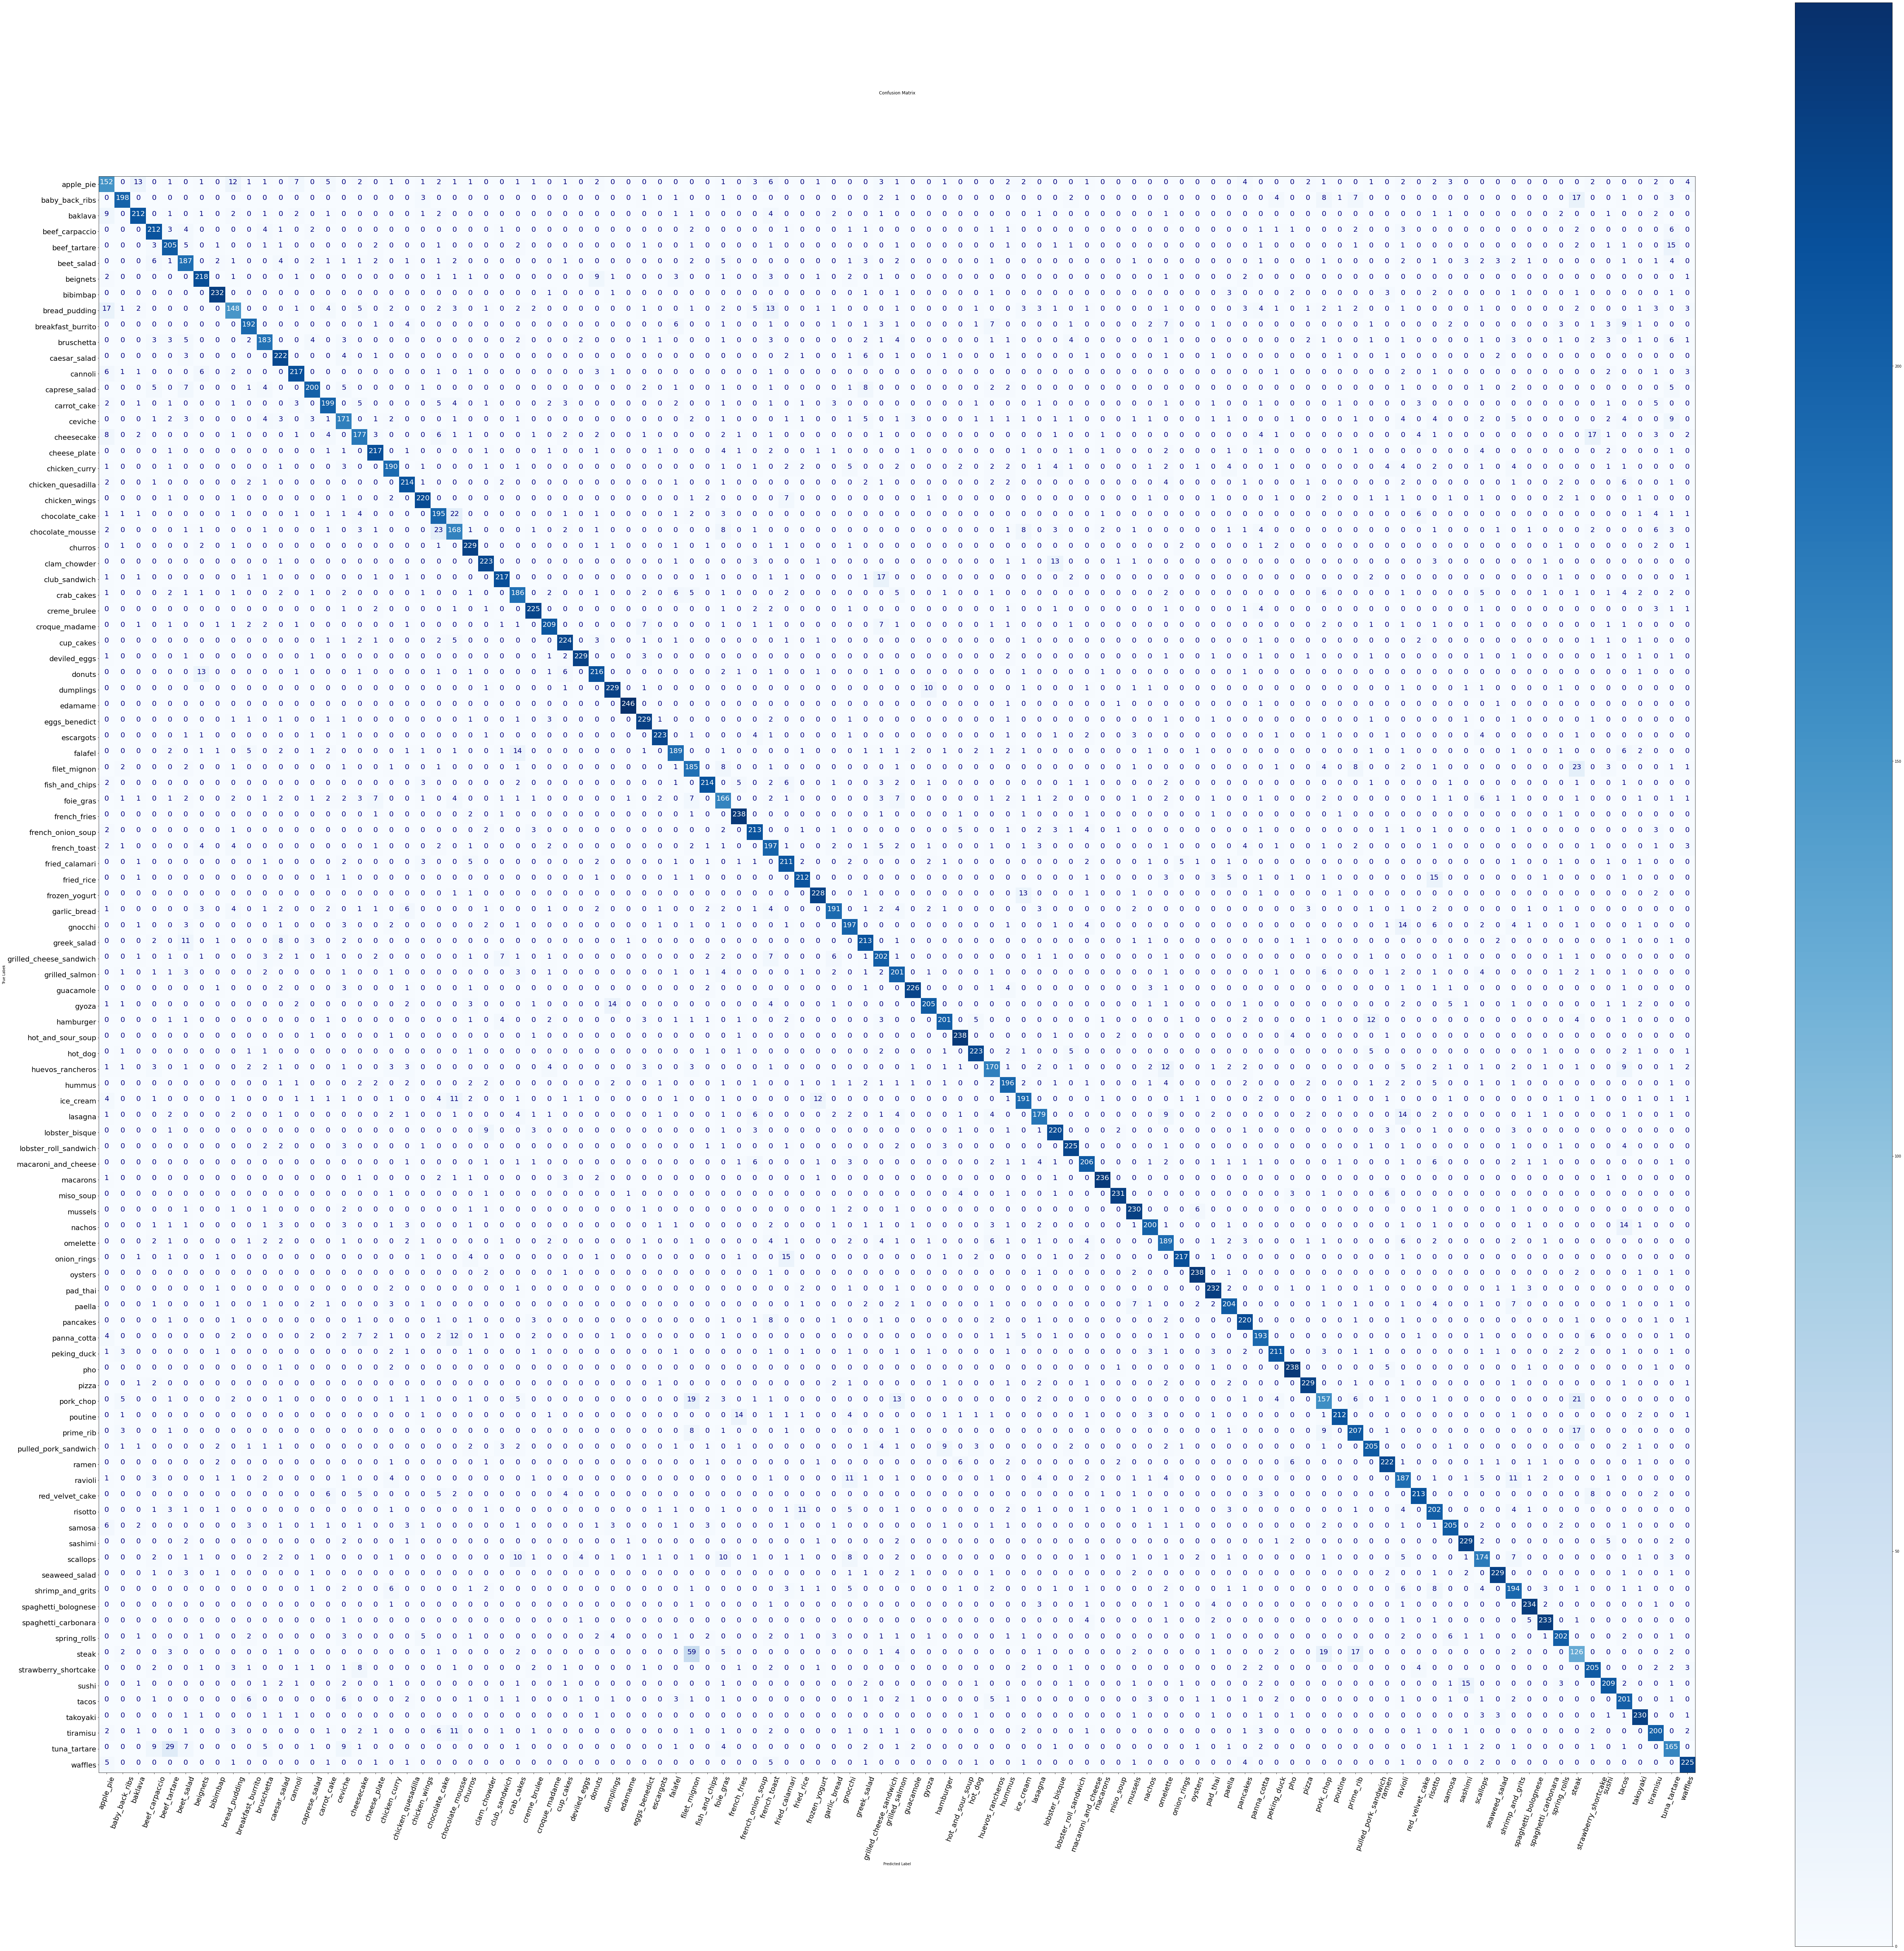

In [ ]:
# Plot confusion matrix
from functions import create_confusion_matrix
create_confusion_matrix(y_true=y_labels,
                        y_pred=pred_classes,
                        classes=class_names,
                        figsize=(100,100),
                        text_size=20,
                        norm=False,
                        savefig=True)

In [ ]:
# classification report

from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.64      0.61      0.62       250
           1       0.88      0.79      0.83       250
           2       0.86      0.85      0.85       250
           3       0.81      0.85      0.83       250
           4       0.75      0.82      0.78       250
           5       0.72      0.75      0.73       250
           6       0.85      0.87      0.86       250
           7       0.93      0.93      0.93       250
           8       0.73      0.59      0.65       250
           9       0.86      0.77      0.81       250
          10       0.79      0.73      0.76       250
          11       0.81      0.89      0.85       250
          12       0.89      0.87      0.88       250
          13       0.87      0.80      0.83       250
          14       0.83      0.80      0.81       250
          15       0.68      0.68      0.68       250
          16       0.76      0.71      0.73       250
          17       0.87    

In [ ]:
# Get a dictionary of the classification report

classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.621676891615542,
  'precision': 0.6359832635983264,
  'recall': 0.608,
  'support': 250},
 '1': {'f1-score': 0.8336842105263157,
  'precision': 0.88,
  'recall': 0.792,
  'support': 250},
 '10': {'f1-score': 0.7577639751552796,
  'precision': 0.7854077253218884,
  'recall': 0.732,
  'support': 250},
 '100': {'f1-score': 0.8806262230919765,
  'precision': 0.8620689655172413,
  'recall': 0.9,
  'support': 250},
 '11': {'f1-score': 0.8457142857142858,
  'precision': 0.8072727272727273,
  'recall': 0.888,
  'support': 250},
 '12': {'f1-score': 0.8803245436105477,
  'precision': 0.8930041152263375,
  'recall': 0.868,
  'support': 250},
 '13': {'f1-score': 0.8316008316008316,
  'precision': 0.8658008658008658,
  'recall': 0.8,
  'support': 250},
 '14': {'f1-score': 0.8122448979591836,
  'precision': 0.8291666666666667,
  'recall': 0.796,
  'support': 250},
 '15': {'f1-score': 0.6826347305389222,
  'precision': 0.6812749003984063,
  'recall': 0.684,
  'support': 250},
 '1

In [ ]:
# Create dictionary for each f1-score

class_f1_scores = {}

# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.621676891615542,
 'baby_back_ribs': 0.8336842105263157,
 'baklava': 0.8531187122736418,
 'beef_carpaccio': 0.8265107212475633,
 'beef_tartare': 0.7839388145315488,
 'beet_salad': 0.7347740667976426,
 'beignets': 0.8599605522682445,
 'bibimbap': 0.928,
 'bread_pudding': 0.6534216335540838,
 'breakfast_burrito': 0.810126582278481,
 'bruschetta': 0.7577639751552796,
 'caesar_salad': 0.8457142857142858,
 'cannoli': 0.8803245436105477,
 'caprese_salad': 0.8316008316008316,
 'carrot_cake': 0.8122448979591836,
 'ceviche': 0.6826347305389222,
 'cheese_plate': 0.868,
 'cheesecake': 0.7344398340248962,
 'chicken_curry': 0.7818930041152264,
 'chicken_quesadilla': 0.8508946322067595,
 'chicken_wings': 0.8817635270541083,
 'chocolate_cake': 0.7543520309477757,
 'chocolate_mousse': 0.6666666666666667,
 'churros': 0.8773946360153257,
 'clam_chowder': 0.8814229249011858,
 'club_sandwich': 0.8839103869653767,
 'crab_cakes': 0.744,
 'creme_brulee': 0.896414342629482,
 'croque_madame': 0.

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
33,edamame,0.984000
63,macarons,0.953535
69,oysters,0.944444
64,miso_soup,0.940937
30,deviled_eggs,0.938525
...,...,...
8,bread_pudding,0.653422
39,foie_gras,0.650980
77,pork_chop,0.646091
0,apple_pie,0.621677


In [ ]:
# Save f1-scores dataframe
f1_scores.to_csv("food101_f1-scores.csv")

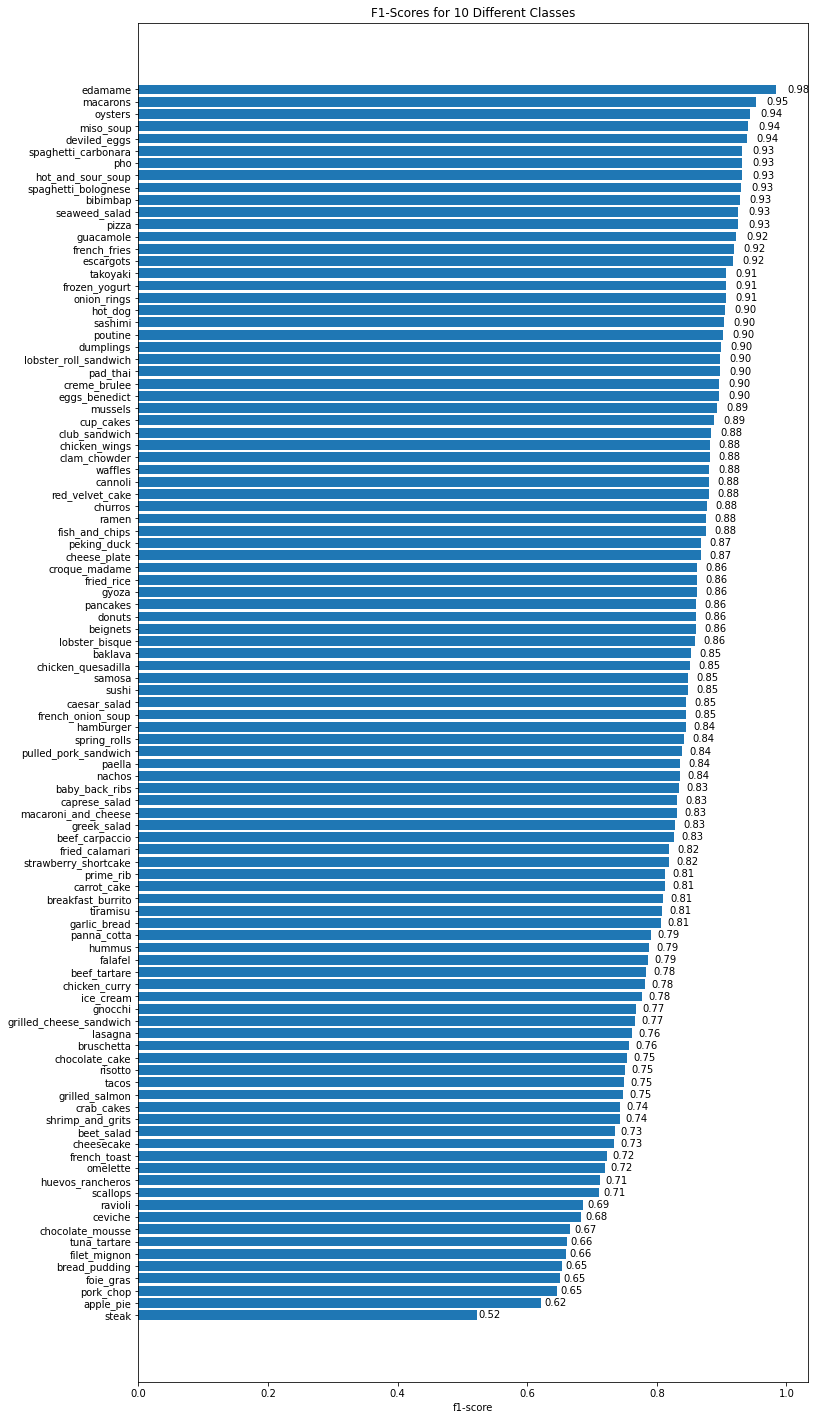

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.035*width, rect.get_y() + rect.get_height(),
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

# **Testing Model on Custom Images**

In [ ]:
!wget -q https://raw.githubusercontent.com/dinachoir/Convolutional-Neural-Network/main/custom-images/01-ravioli.jpg
!wget -q https://raw.githubusercontent.com/dinachoir/Convolutional-Neural-Network/main/custom-images/01-apple_pie.jpg
!wget -q https://raw.githubusercontent.com/dinachoir/Convolutional-Neural-Network/main/custom-images/01-baklava.jpg
!wget -q https://raw.githubusercontent.com/dinachoir/Convolutional-Neural-Network/main/custom-images/01-ceviche.jpg
!wget -q https://raw.githubusercontent.com/dinachoir/Convolutional-Neural-Network/main/custom-images/01-guacamole.jpg
!wget -q https://raw.githubusercontent.com/dinachoir/Convolutional-Neural-Network/main/custom-images/01-steak.jpg
!wget -q https://raw.githubusercontent.com/dinachoir/Convolutional-Neural-Network/main/custom-images/02-fried_rice.jpg
!wget -q https://raw.githubusercontent.com/dinachoir/Convolutional-Neural-Network/main/custom-images/02-pizza.jpg

In [ ]:
custom_food_images = ["/content/01-apple_pie.jpg","/content/01-baklava.jpg","/content/01-ceviche.jpg","/content/01-guacamole.jpg","/content/01-ravioli.jpg","/content/01-steak.jpg","/content/02-fried_rice.jpg","/content/02-pizza.jpg"]
custom_food_images

['/content/01-apple_pie.jpg',
 '/content/01-baklava.jpg',
 '/content/01-ceviche.jpg',
 '/content/01-guacamole.jpg',
 '/content/01-ravioli.jpg',
 '/content/01-steak.jpg',
 '/content/02-fried_rice.jpg',
 '/content/02-pizza.jpg']

In [ ]:
def load_prep_image(filename,img_shape=224, scale=True):
  """
  Read an image from filename, turn it into a tensor, and reshape it to (img_shape, img_shape, color_channel)
  --
  Parameters:
  filename (str) : filename of target image
  img_shape (int) : size of target image to be resized
  scale (boolean) : whether to scale pixal values of image to range(0,1), default=True
  """
  # read image from the target file
  img = tf.io.read_file(filename)

  # decode image into tensor
  img = tf.image.decode_jpeg(img) # color_channels=3 by default in decode_jpeg

  # resize the image to the same size as the model has been trained on
  img = tf.image.resize(img, size=[img_shape, img_shape])

  img = tf.cast(img, tf.float32)

  # rescale the image
  if scale:
    return img/255.
  else:
    return img

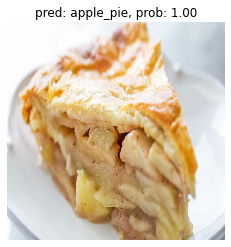

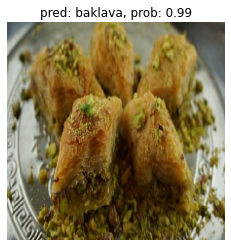

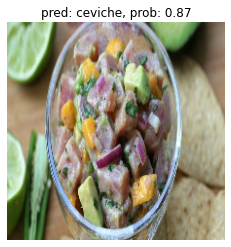

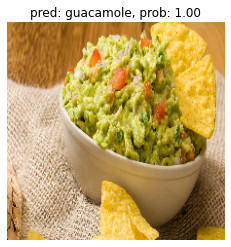

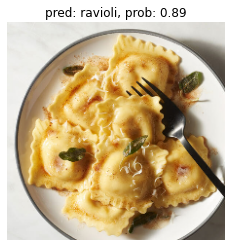

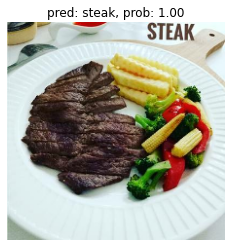

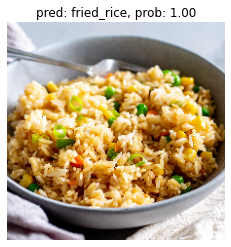

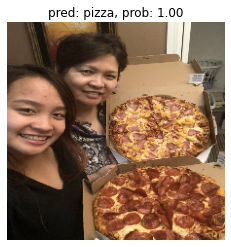

In [ ]:
# Make predictions on custom food images

for img in custom_food_images:
  img = load_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model_2.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label

  # plot the image
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

**Conclusion**

Testing model results that 8 out of 8 custom images are correctly predicted. Even with the lowest f1-score (f1-score=0.52) on predicting steak class, the model turns out a high prediction probability on steak image (prob=1). It can be concluded that the computer vision model is pretty good at predicting food images with overall accuracy 82.7%. This model beats the result mentioned in [DeepFood paper](https://arxiv.org/abs/1606.05675) for Food101 (77.4% accuracy).